<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5511-gan/blob/main/monet_painting_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5: Monet painting - GAN model

DTSA 5511 - Intro to Deep Learning

Link to GitHub repo:

https://github.com/FleaBusyBeeBergs/dtsa5511-rnn.git

## 1. Introduction

In [ ]:
# general utilities
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

import tensorflow as tf

In [ ]:
# kaggle stuffs
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
# note to self: file is in dtsa5511 folder

In [4]:
!kaggle competitions download -c gan-getting-started -p /content/data > /dev/null
!unzip /content/data/gan-getting-started.zip -d ./data > /dev/null

100% 367M/367M [00:00<00:00, 517MB/s]


## 2. EDA

EDA with TFRecords is different from the usual dataframe EDA. In this dataset, there are only images, and no labels.

In [7]:
# load data
monet_files = tf.io.gfile.glob('./data/monet_tfrec/*.tfrec')
photo_files = tf.io.gfile.glob('./data/photo_tfrec/*.tfrec')

print('money tfrec length:' , len(monet_files))
print('photo tfrec length:' , len(photo_files))

money tfrec length: 5
photo tfrec length: 20


In [11]:
# function to parse images
def decode_image(example_proto):
  feature_description = {
      'image': tf.io.FixedLenFeature([], tf.string),
       }

  example = tf.io.parse_single_example(example_proto, feature_description)

  image = tf.image.decode_jpeg(example['image'], channels = 3)
  image = tf.cast(image, tf.float32) / 255.0
  image = tf.image.resize(image, [256, 256])
  return image

In [12]:
# create dataset
monet_ds = tf.data.TFRecordDataset(monet_files).map(decode_image).batch(16)
photo_ds = tf.data.TFRecordDataset(photo_files).map(decode_image).batch(16)

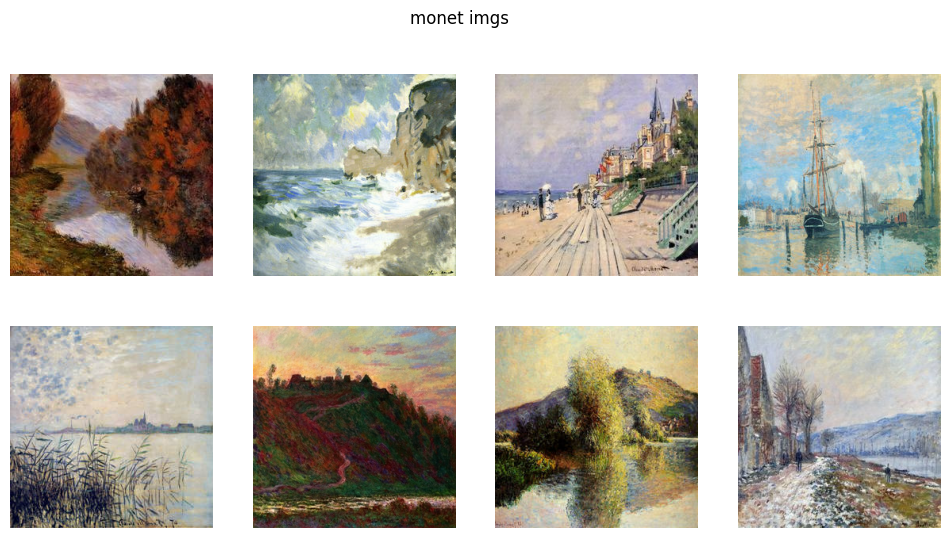

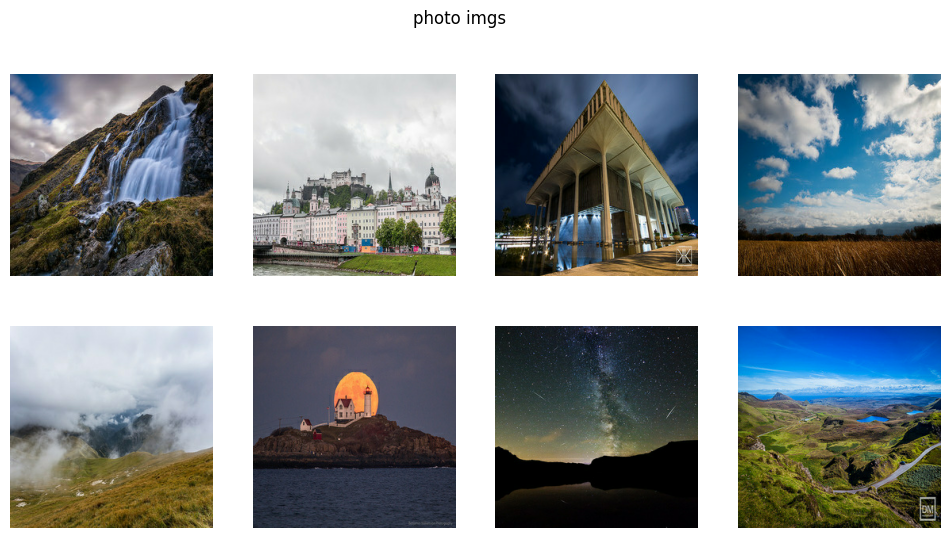

In [13]:
# preview images
def show_batch(dataset, title):
  plt.figure(figsize = (12, 6))
  for images in dataset.take(1):
    for i in range(8):
      ax = plt.subplot(2, 4, i+1)
      plt.imshow(images[i])
      plt.axis('off')
  plt.suptitle(title)
  plt.show()

show_batch(monet_ds, 'monet imgs')
show_batch(photo_ds, 'photo imgs')


Text(0.5, 1.0, 'avg pixel intensity dist')

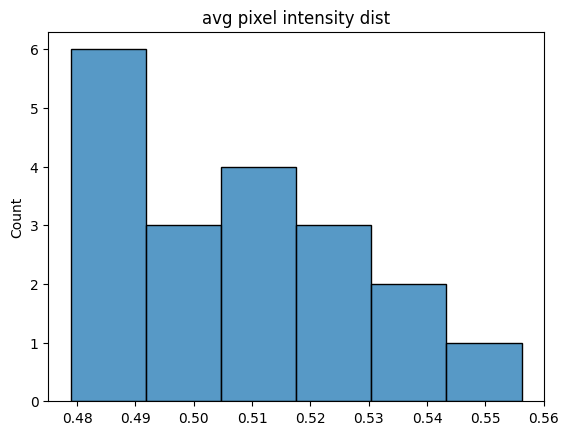

In [16]:
# img level stats - mean, std, pixel dist.
means = []
for img in monet_ds.take(500):
  means.append(tf.reduce_mean(img).numpy())

sns.histplot(means)
plt.title('avg pixel intensity dist')

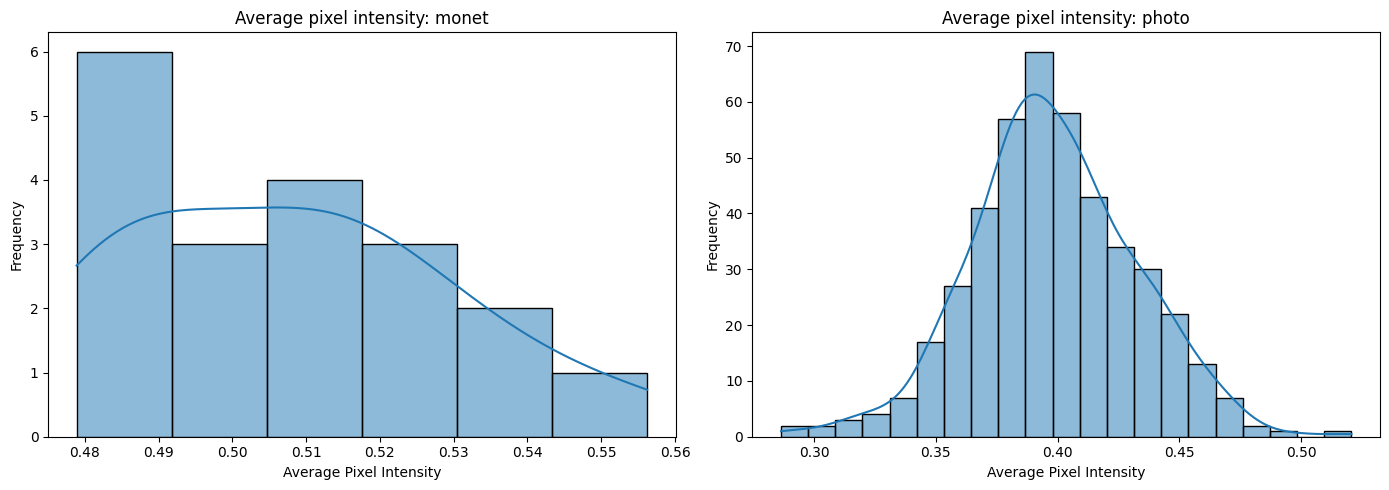

In [23]:
# Create a list containing the two datasets
datasets = [monet_ds, photo_ds]
dataset_names = ['monet', 'photo']

# Prepare the subplot grid
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Iterate through the datasets and corresponding axes
for idx, (dataset, name) in enumerate(zip(datasets_to_analyze, dataset_names)):
    means = []
    for img in dataset.take(500):
        means.append(tf.reduce_mean(img).numpy())

    sns.histplot(means, ax=axes[idx], kde=True)
    axes[idx].set_title(f'avg pixel intensity: {name}')
    axes[idx].set_xlabel('avg pixel intensity')
    axes[idx].set_ylabel('freq')

plt.tight_layout()
plt.show()

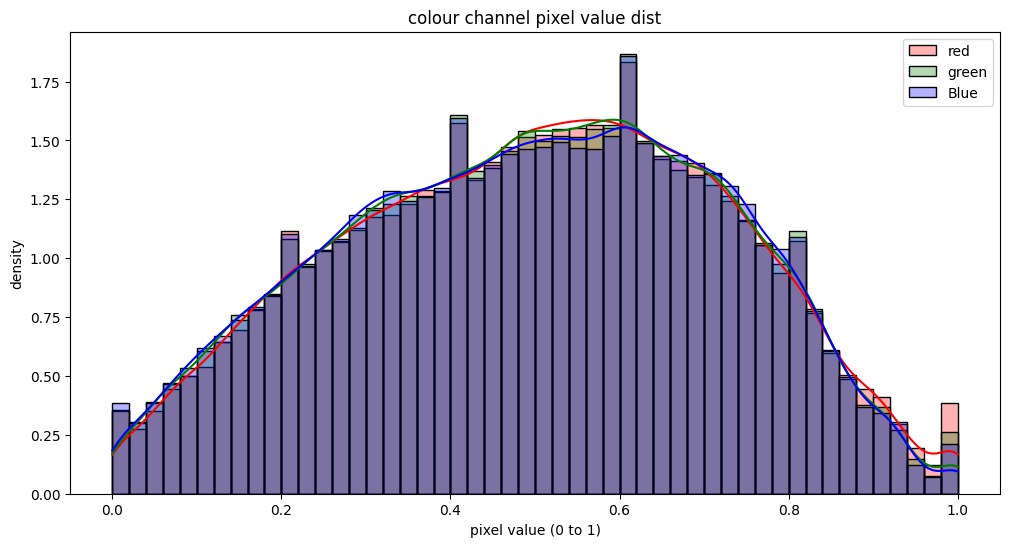

In [19]:
# img level stats - colour channel dist
r_vals, g_vals, b_vals = [], [], []

for img in monet_ds.take(500):
  img_np = img.numpy()
  r_vals.extend(img_np[:, :, 0].flatten())
  g_vals.extend(img_np[:, :, 1].flatten())
  b_vals.extend(img_np[:, :, 2].flatten())

plt.figure(figsize=(12, 6))

sns.histplot(r_vals,
             color = 'red',
             label = 'red',
             bins = 50,
             stat = 'density',
             kde = True,
             alpha = 0.3)
sns.histplot(g_vals,
             color = 'green',
             label = 'green',
             bins = 50, stat = 'density',
             kde = True,
             alpha = 0.3)
sns.histplot(b_vals,
             color = 'blue',
             label = 'Blue',
             bins = 50,
             stat = 'density',
             kde = True,
             alpha = 0.3)

plt.title('colour channel pixel value dist')
plt.xlabel('pixel value (0 to 1)')
plt.ylabel('density')
plt.legend()
plt.show()

From the histogram above, the colours red, green, and blue seem to be used equally in the Monet paintings.

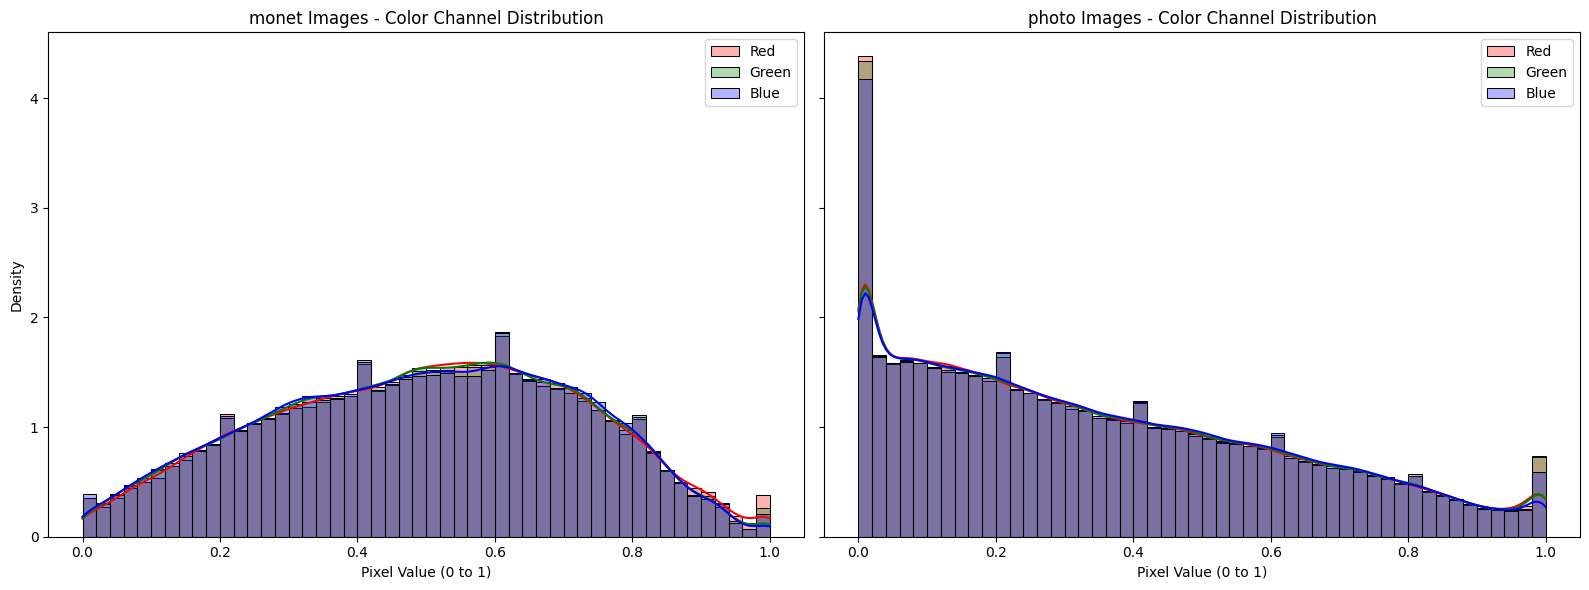

In [25]:
# Create subplot grid: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Loop through datasets and axes
for idx, (dataset, name) in enumerate(zip(datasets, dataset_names)):
    r_vals, g_vals, b_vals = [], [], []

    # Collect color channel values
    for img in dataset.take(100):
        img_np = img.numpy()
        r_vals.extend(img_np[:, :, 0].flatten())
        g_vals.extend(img_np[:, :, 1].flatten())
        b_vals.extend(img_np[:, :, 2].flatten())

    # Plot histograms on the correct axis
    sns.histplot(r_vals, color='red', label='Red', bins=50, stat='density', kde=True, alpha=0.3, ax=axes[idx])
    sns.histplot(g_vals, color='green', label='Green', bins=50, stat='density', kde=True, alpha=0.3, ax=axes[idx])
    sns.histplot(b_vals, color='blue', label='Blue', bins=50, stat='density', kde=True, alpha=0.3, ax=axes[idx])

    # Customize the plot
    axes[idx].set_title(f'{name} Images - Color Channel Distribution')
    axes[idx].set_xlabel('Pixel Value (0 to 1)')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()

# Adjust layout
plt.tight_layout()
plt.show()